# Data preparation for *Nature* Herd Immunity news feature

We want to recreate this chart from [Our World In Data](https://ourworldindata.org/covid-vaccinations), using the downloadabel CSV file that they provide.

## Load the packages we will need

In [17]:
library(DT)

In [111]:
library(repr)

In [6]:
library(readr)

In [118]:
library(dplyr, warn.conflicts = FALSE)

In [48]:
library(ggplot2)

In [119]:
library(scales, warn.conflicts = FALSE)

In [120]:
library(lubridate, warn.conflicts = FALSE)

## Download the data

Load the data as CSV file from [Our World In Data](https://ourworldindata.org/covid-vaccinations)

In [19]:
df_csv <- read.csv("https://covid.ourworldindata.org/data/owid-covid-data.csv?v=2021-03-09", stringsAsFactors=F)

## Look at the data

In order to recreate the chart from Our World in Data, it looks like `total_vaccinations_per_hundred ` is the best bet. Although, what is the difference between 'total' and `people_vaccinated_per_hundred`?

In [20]:
head(df_csv)

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
AFG,Asia,Afghanistan,2020-02-24,1,1,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-25,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-26,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-27,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-28,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-29,1,0,0.143,NA,NA,0,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511


##  Filter and format the data

Let's extract just the country codes, names, dates and total vaccinations per hundred.

And reduce the list of countries to just the ones we want to show.

The filter to just show dates in 2021.

In [132]:
countries_to_show <- c(
"Israel",
"United Arab Emirates",
"United Kingdom",
"United States",
"Chile",
"European Union",
"Brazil",
"Russia",
"World",
"China",
"Bangladesh",
"Mexico",
"Indonesia"
)

In [137]:
df_formatted <- df_csv %>%
    # Reduce to just the columns that we want
    select(iso_code, location, date, total_vaccinations_per_hundred) %>%
    # Format the dates as actual dates, rather than strings
    mutate(date_formatted = ymd(date)) %>%
    # Cut out any dates before 2021
    filter(date_formatted > "2020-12-31") %>%
    # Cut out any country that's not in the list
    subset( location %in% countries_to_show)

## Plot a chart of the result

Warning message:
“Removed 91 rows containing missing values (geom_path).”

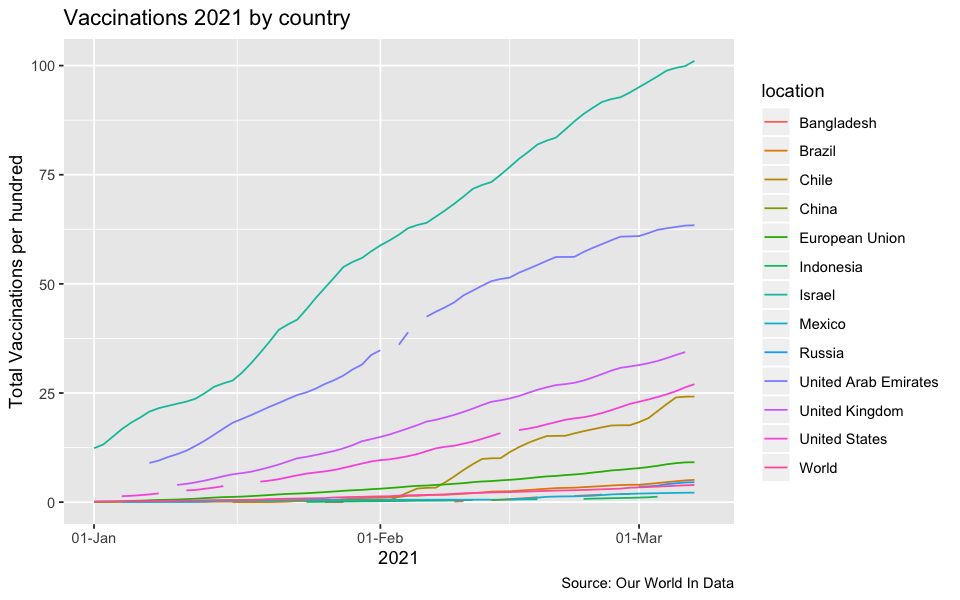

In [142]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=df_formatted) +
    aes(x=date_formatted, y=total_vaccinations_per_hundred, group=location, color=location)+ 
    geom_line() +
    scale_x_date(date_breaks = "1 month", labels = date_format("%d-%b")) + 
    labs(y="Total Vaccinations per hundred", x="2021", title="Vaccinations 2021 by country", caption="Source: Our World In Data")